In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.signal import butter, lfilter, find_peaks
from sklearn import decomposition
from sklearn.metrics import pairwise_distances
import gower

import mne

import os


import glob

from utils import *


from time import sleep
from tqdm import tqdm

In [2]:
foldername = '../../../Originals/procesados/'

In [3]:
filenames = sorted(os.listdir(foldername))

# Concatenación de todos los eeg data

In [4]:
all_eeg_data = []
for f in filenames:
    eeg_data, _, _, _ = get_egg_data(foldername + f)
    all_eeg_data.append(eeg_data)

In [5]:
mont1020 = mne.channels.make_standard_montage('standard_1020')
# Choose what channels you want to keep 
# Make sure that these channels exist e.g. T1 does not exist in the standard 10-20 EEG system!
kept_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 
                 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'FC1', 'FC2',
                 'FC5', 'FC6','CP1','CP2','CP5','CP6','AFz','Fpz','POz']

ind = [i for (i, channel) in enumerate(mont1020.ch_names) if channel in kept_channels]
mont1020_30 = mont1020.copy()
# Keep only the desired channels
mont1020_30.ch_names = [mont1020.ch_names[x] for x in ind]
kept_channel_info = [mont1020.dig[x+3] for x in ind]
# Keep the first three rows as they are the fiducial points information
mont1020_30.dig = mont1020.dig[0:3]+kept_channel_info
info_eeg = mne.create_info(ch_names=mont1020_30.ch_names, sfreq=128,
                            ch_types='eeg').set_montage(mont1020_30)

In [6]:
df_all_eeg_data = pd.concat([pd.DataFrame(x.T) for x in all_eeg_data])

In [7]:
df_all_eeg_data.reset_index(inplace=True, drop=True)

In [8]:
all_eeg_data_numpy = df_all_eeg_data.to_numpy()

In [9]:
df_all_eeg_data.shape

(76810, 30)

In [10]:
df_all_eeg_data = df_all_eeg_data.T

# Tarea 1: Inspección de los mapas topográficos para los máximos de GFP

### No entiendo muy bien que se refiere con esto 
Encontrar los picos máximos del GFP (PGF P ), guardar los mapas para cada máximo
( ~xn). \ 
Estudiar la presencia de mapas outliers. Para ello puede usar PCA y/o clustering jerarquico y/o matriz de distancias.

In [11]:
srate = 128
n_ch = 30

In [12]:
df_all_eeg_data.shape

(30, 76810)

In [13]:
gfp, gfp_peaks, gfp_values, gfp2, n_gfp = calculo_gfp(df_all_eeg_data, srate, 'Nope')

In [14]:
gfp.shape

(76810,)

In [15]:
gfp_peaks

array([    5,    10,    17, ..., 76796, 76800, 76807])

In [16]:
gfp_values

5        7.276428
10       5.238829
17       3.388585
21       4.178985
28       4.070243
           ...   
76783    4.182255
76788    6.040142
76796    5.606688
76800    5.746762
76807    4.397674
Length: 13135, dtype: float64

## Sacar los outliers con PCA y/o clustering jerarquico y/o matriz de distancias

In [17]:
X = df_all_eeg_data.T.loc[gfp_peaks].T

In [18]:
pca = decomposition.PCA(n_components=5)
pca.fit(X)

PCA(n_components=5)

In [19]:
pcs = pca.transform(X)
print(pcs.shape)

(30, 5)


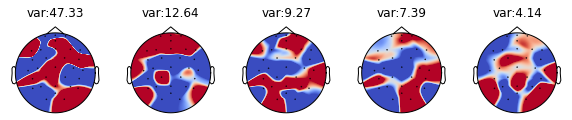

In [20]:
var = pca.explained_variance_ratio_

fig2, ax = plt.subplots(ncols=pcs.shape[1], figsize=(10, 3), gridspec_kw=dict(top=0.9),
                        sharex=True, sharey=True)


for p in range(pcs.shape[1]):
    mne.viz.plot_topomap(pcs[:,p], info_eeg, 
                         cmap='coolwarm', vmin=-100,vmax=100, contours=0,
                         axes=ax[p],show=False)
    
    ax[p].set_title('var:'+str(round(var[p]*100,2)) )

In [21]:
# Calculo la distnacia euclidiana para 
# input shape (n_samples,n_features) por eso uso X.T
dist_mat_euc = pairwise_distances(X.T, X.T, metric='euclidean')
dist_mat_euc.shape

(13135, 13135)

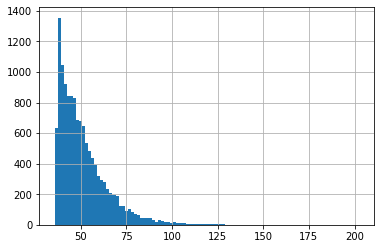

In [22]:
# Calculo la dist media y le agrego el indice que tiene X.T, que sería el mapa la instante t.
df_dist_mat_euc = pd.DataFrame(dist_mat_euc, index=X.T.index)
mean_dists = df_dist_mat_euc.mean(axis=1)
mean_dists.hist(bins=100)

In [23]:
# Tiro el 5 poricento a derecha,
X.T[mean_dists < mean_dists.quantile(q=0.90)]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
5,-4.90590,-5.8438,-6.3806,5.61930,13.21500,-10.3510,-0.732880,6.38300,-10.14500,-1.57980,...,-1.13120,-6.1538,-1.47650,1.92040,5.56840,-4.75890,3.1592,-6.66760,15.31600,-7.45820
10,7.63770,5.8280,-5.0308,-9.04660,-7.75150,4.4265,0.030366,-2.99750,1.61370,6.32360,...,2.53860,-2.0199,5.09860,-6.50460,-3.08470,0.46798,4.2657,4.08880,-10.48200,6.45020
17,5.90130,-1.5379,-3.5369,-3.13850,1.71550,2.6414,0.919840,3.78090,1.14980,-0.70753,...,7.43410,-2.2452,0.64295,-5.21120,-3.52040,-5.38000,-1.1226,-2.19410,0.20288,2.34380
21,-1.68830,-6.9348,1.0430,5.23440,7.25420,-6.8694,-1.450900,5.83270,-0.81021,-4.38280,...,2.91930,-4.0898,-3.08910,3.29280,3.30410,-1.75380,2.3473,-3.61120,5.32080,-3.41470
28,-0.79600,-1.6378,5.9023,2.30480,-2.57290,2.7789,-0.978660,0.17811,-1.85080,-0.17094,...,-5.62320,0.4648,-2.75840,6.10500,5.25630,-2.40930,-7.2843,3.59050,3.74620,0.15031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76783,3.64540,2.6903,-1.9686,-3.82580,-0.82942,4.4352,5.491600,5.31490,2.37180,-0.15966,...,-2.78500,1.5869,-0.61506,-1.81290,-7.79400,1.93510,-2.7693,3.32890,-3.60430,4.49270
76788,-4.59410,-5.3179,-1.9670,2.49390,1.60230,-13.6550,-9.927800,-2.01680,-4.04800,0.25884,...,-0.99982,-7.5061,6.66900,0.96319,4.16370,-4.67180,10.1370,-7.74520,6.88590,-4.51790
76796,-0.23344,-2.3636,-7.4530,-3.94020,0.96299,-9.4888,-6.900400,-3.00350,0.17497,4.30240,...,4.45430,-8.2994,10.63400,-4.05610,0.37701,-5.20780,8.6750,-0.99986,-2.01650,-1.53520
76800,-0.88499,4.5809,6.2678,6.12990,-2.76110,-3.4339,-5.628000,-8.34130,-0.41654,1.08290,...,3.62930,-1.1062,-1.37160,4.93870,7.67810,1.53770,-1.8493,2.57210,-0.18579,-2.06950


In [24]:
X_filtered = X.T[mean_dists < mean_dists.quantile(q=0.95)].T
X_filtered.shape

(30, 12478)

In [25]:
gfp_values_filt = gfp_values[mean_dists < mean_dists.quantile(q=0.95)]

In [26]:
gfp_values_filt.shape, X_filtered.shape

((12478,), (30, 12478))

Hice esta de pura curisoidad, cómo el kmenas modificado mira la distancia 

In [27]:
from sklearn.metrics.pairwise import cosine_distances

In [28]:
# input shape (n_samples,n_features) por eso uso X.T
# dist cosine = 1.0 - cosine_similarity(X, Y), cos_sim = <X, Y> / (||X||*||Y||)
# Esta distancia mira el angulo entre vectores, si aputnan en la misma direci'on da 0,
#si apuntan en direncci'on contraria da 2 y si son ortogonales da 1.
dist_mat_cos = pairwise_distances(X.T,X.T,metric='cosine')
dist_mat_cos.shape

(13135, 13135)

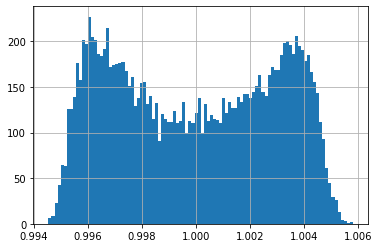

In [29]:
df_dist_mat_cos = pd.DataFrame(dist_mat_cos)
df_dist_mat_cos.mean(axis=1).hist(bins=100)

In [30]:
# Ac'a se ve que en promedio son bastante ortogonales,
# creo que este gr'afico no aporta nada pero quer'ia ver que daba porque
# el kmeans_mod se hace con la proyeci'on

In [31]:
# plt.figure(figsize=(15,10))
# s_rate=128
# start=0
# end=60

# x = np.arange(0, df_all_eeg_data.T.shape[1])/128
# #y = gfp.
# plt.plot(x, gfp.values)
# plt.xlabel('tiempo [S]', fontsize=24)
# plt.ylabel('GFP', fontsize=20)
# plt.title(f'GFP y picos cada 80ms Sujeto Pos', fontsize=24)
# peaks, _ = find_peaks(gfp, height=(0,np.inf),distance=10)
# for ind in peaks:
#     plt.plot(x[ind],gfp[ind],'ro')

# # plt.savefig(f'../images/grafico_GFP_sujeto_{sujeto}_pos')
# plt.show()

# Tarea 2: Calculo de microestados utilizando k-means modificados
Aplicar el algoritmo de K-means modificado sobre los PGF P . Utilizar k = 2 − 10. ¿Es necesario repetir el procedimiento más de una vez para cada valor de k?
Decidir el mejor valor de k. Calcular el promedio de Silhoutte, el parámetro de Validación Cruzada y la Variancia global explicada para cada k. Relizar gráfico de las tres medidas para el k correspondiente.
Para el valor de k óptimo realizar el perfil de Silhoutte completo. Inspeccionar, a partir de esta última figura, la presencia de outliers, si es necesario descartarlos del análisis y volver a calcular los clusters para este valor de k.

In [32]:
from utils import kmeans3
from utils import silhoutte_modificado2
from utils import grafica_sil

In [33]:
# maps, L, cv = kmeans3(X.values, gfp_values, 2)

## ¿Es necesario repetir el procedimiento más de una vez para cada valor de k? Supongo que hay que hacer un CV ya que hay una inicialización random al principio

## Hacer el for loop sobre k 2 - 10. Calcular el silhoutte y ver cuales son las otras métricas. Todas meterlos en un dataframe.


- Si todo esto está bien, faltaría ver cómo calcular la variancia global explicada para cada J y analizar la presencia de outliers en el último gráfico, etc.


In [34]:
def gevCluster(X, gfp_values, centroide):
    """
    X: np.array de vectores file, (n_samples, vec_dim) 
    centroide: vector columna contra el cual se calcula el GEV,
    gfp_values: altura del pico correspodiente a cada mapa de X
    """
    corr = (np.dot(X, centroide) / (np.linalg.norm(X) * np.linalg.norm(centroide)))**2
    gfp_2 = gfp_values**2
    sum_gfp_2 = gfp_2.sum()
    return (corr * (gfp_2 / sum_gfp_2)).sum()

In [35]:
def clusterAnalysis(X, gfp_values):
    """
    """
    k = []
    maps_k = []
    L_k = []
    cv_k = []
    sil_k = []
    gevs = {}

    for num_clusters in tqdm(range(2,11)):
        maps, labels, cv = kmeans3(X.values, gfp_values, num_clusters, maxiter=1000)
        maps_norm = maps - maps.mean(axis=1, keepdims=True)
        maps_norm /= maps_norm.std(axis=1, keepdims=True)
        
        X_norm = X.values - X.values.mean(axis=1, keepdims=True)
        X_norm /= X_norm.std(axis=1, keepdims=True)
        
        C = np.dot(X_norm.T, maps_norm.T) / n_ch
        
        gev = np.zeros(num_clusters)
        
        for z in range(num_clusters):
            r = labels==z
            gev[z] = np.sum(gfp_values[r]**2 * C[r,z]**2)/gfp2
        
        gevs[f'k={num_clusters}'] = gev.sum().round(3)

#         for cluster in range(0, num_clusters):
#             gev_cluster = gevCluster(X.T.values[labels == cluster],gfp_values[labels == cluster],maps[cluster])
#             gev[f'k={num_clusters}'].append(gev_cluster)

#         gev[f'k={num_clusters}'] = sum(gev[f'k={num_clusters}'])

        k.append(num_clusters)
        maps_k.append(maps)
        L_k.append(labels)
        cv_k.append(cv)
        sil = silhoutte_modificado2(maps, X, labels, X.shape[0], num_clusters)
        sil_avg = np.mean(sil)
        sil_k.append(sil_avg)
    return k, maps_k, L_k, cv_k, sil, sil_avg, sil_k, gevs

In [36]:
# # --- GEV ---
#     maps_norm = maps - maps.mean(axis=1, keepdims=True)
#     maps_norm /= maps_norm.std(axis=1, keepdims=True)

#     # --- correlation data, maps ---
#     C = np.dot(data_norm, maps_norm.T)/n_ch
#     #print("C.shape: " + str(C.shape))
#     #print("C.min: {C.min():.2f}   Cmax: {C.max():.2f}")

#     # --- GEV_k & GEV ---
#     gev = np.zeros(n_clusters)
#     for k in range(n_clusters):
#         r = L==k
#         gev[k] = np.sum(gfp[r]**2 * C[r,k]**2)/gfp2
#     print(f"\n[+] Global explained variance GEV = {gev.sum():.3f}")
#     for k in range(n_clusters):
#         print(f"GEV_{k:d}: {gev[k]:.3f}")

In [37]:
# Preguntar!
k, maps_k, L_k, cv_k, sil, sil_avg, sil_k, gev = clusterAnalysis(X_filtered, gfp_values_filt)

100%|██████████| 9/9 [01:20<00:00,  8.97s/it]


Text(0.5, 1.0, 'Silhoutte en función del k')

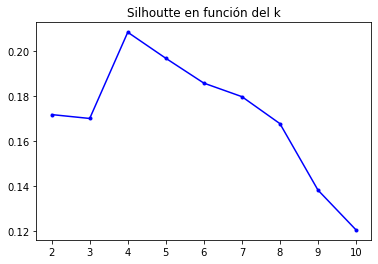

In [38]:
plt.plot(k, sil_k,'b.-')
plt.title('Silhoutte en función del k')

Text(0.5, 1.0, 'CV en función del k')

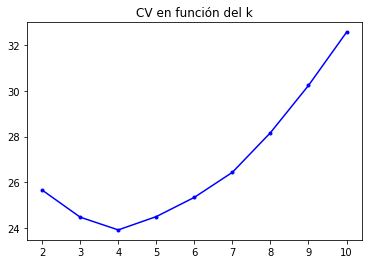

In [39]:
plt.plot(k, cv_k, 'b.-')
plt.title('CV en función del k')

Text(0.5, 1.0, 'GEV en función de k')

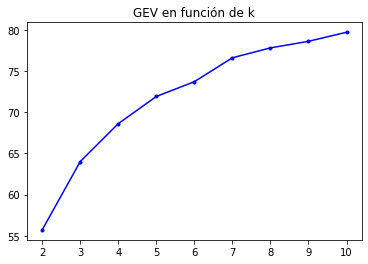

In [40]:
# Preguntar!
plt.plot((np.arange(2,11)),100*np.array(list(gev.values())),'b.-')
plt.title('GEV en función de k')

In [41]:
# Creo que todos los GEV deberian ir entre 0 y 1, El ultimo da un poco mayor a uno, no se si ser'a un error numerico

In [42]:
maps, L, cv = kmeans3(X_filtered.values, gfp_values_filt, n_maps = 4, maxiter=2000)
sil = silhoutte_modificado2(maps, X_filtered.values, L, 30, 4)

In [43]:
pd.Series(L).value_counts()

1    3941
3    3635
0    2687
2    2215
dtype: int64

For n_clusters = 4 The average silhouette_score is : 0.20473366548709587


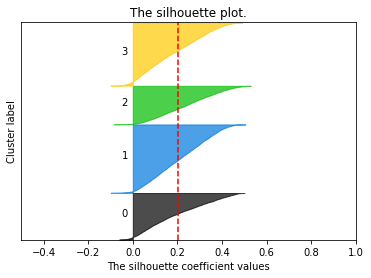

In [44]:
grafica_sil(4, sil, L)

In [45]:
X_clean = X_filtered.T[np.array(sil)>0].T
gfp_values_clean = gfp_values_filt.T[np.array(sil)>0]

In [46]:
k, maps_k, L_k, cv_k, sil, sil_avg, sil_k, gev = clusterAnalysis(X_clean, gfp_values_clean)

100%|██████████| 9/9 [01:07<00:00,  7.47s/it]


In [47]:
# maps, L, cv = kmeans3(X_clean.values, gfp_values_clean, n_maps = 4, maxiter=1000)
sil = silhoutte_modificado2(maps_k[2], X_clean.values, L_k[2], 30, 4)

For n_clusters = 4 The average silhouette_score is : 0.22056743692000666


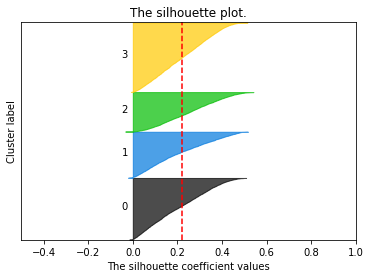

In [48]:
grafica_sil(4, sil, L_k[2])

Text(0.5, 1.0, 'Silhoutte en función del k')

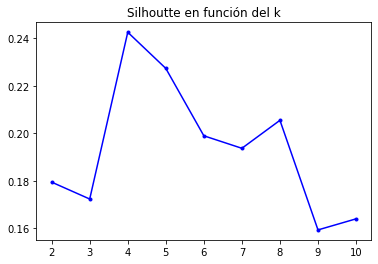

In [49]:
plt.plot(k, sil_k,'b.-')
plt.title('Silhoutte en función del k')

Text(0.5, 1.0, 'CV en función del k')

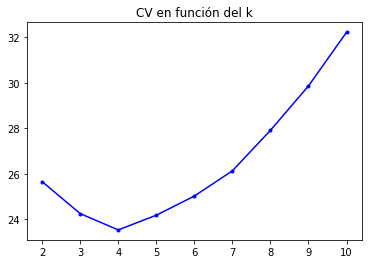

In [50]:
plt.plot(k, cv_k, 'b.-')
plt.title('CV en función del k')

# Tarea 3: Validación externa de los microestados
Realizar al menos dos métodos de clustering diferentes para los ~xn. Determinar la distancia que va a utilizar. Justificar brevemente porque se eligen esos métodos y nociones de distancia. Realice una inspección de las características de los clusters hallados y de los prototipos de cada cluster en caso que los hubiese (o de ejemplos en el caso que no), comparar con los encontrados por el método de k-means modificado.
Calcular la matriz de confusión entre algoritmos. Determinar el índice Rand.

In [51]:
from sklearn_extra.cluster import KMedoids
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering

## Probamos distintos tipos de clustering: por prototipo y por densidad

### K-MEDOIDS es menos sensible a los outliers, nosotros los identificamos y limpiamos en el paso anterior. Es más flexible para otras distancias. NO escala bien para N grandes.

# Cluster por prototipo

In [52]:
KM_med = KMedoids(n_clusters=4, metric='cosine', init='k-medoids++').fit(X_clean.T.values)

In [53]:
print(KM_med.labels_)
print(KM_med.medoid_indices_)

[1 2 1 ... 2 0 3]
[2028 2079  702 4310]


In [54]:
print(silhouette_score(X_clean.T, KM_med.labels_, metric='cosine'))

0.21315395468257375


## Clustering jerárquico
Variar parámetro linkage

In [55]:
agg_clustering = AgglomerativeClustering(n_clusters=4, affinity='cosine', linkage='average').fit(X_clean.T)

In [56]:
agg_clustering

AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=4)

In [57]:
silhouette_score(X_clean.T, agg_clustering.labels_, metric='cosine')

0.16856078539201522

In [58]:
# Mejor métrica: cosine.
# Dan info de similitudes. Es mas importante que las amplitudes

# mirar el perfil del silh

In [59]:
tmp = pd.DataFrame({'kmeans': L_k[2], 'kmedoids': KM_med.labels_})
ct0 = pd.crosstab(tmp['kmeans'], tmp['kmedoids'])
ct0

kmedoids,0,1,2,3
kmeans,,,,
0,259,1428,1692,31
1,198,135,1014,1197
2,631,140,435,977
3,1617,1375,420,422


## Indice Rand

The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

In [60]:
from sklearn.metrics import adjusted_rand_score

In [61]:
i_rand = adjusted_rand_score(L_k[2], KM_med.labels_)

In [62]:
i_rand

0.15927809879986699

In [63]:
km_clusters_centers = np.array([(x - x.mean())/(x.std()) for x in KM_med.cluster_centers_])

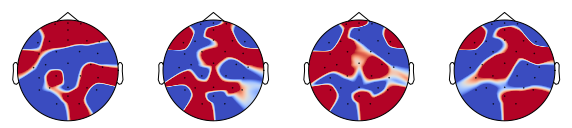

In [64]:
fig3, ax = plt.subplots(ncols=4, figsize=(10, 4), gridspec_kw=dict(top=0.9),
                        sharex=True, sharey=True)

for n in range(4):
    mne.viz.plot_topomap(km_clusters_centers[n,:].T,info_eeg,
                         vmin=-0.3,vmax=0.3, cmap='coolwarm',
                         contours=0, axes=ax[n],show=False)
plt.show()

In [65]:
X_clean_pred = X_clean.T.copy()

In [66]:
X_clean_pred['class'] = L_k[2]

In [67]:
X_clean_pred.sort_values('class', inplace=True)

In [68]:
X_clean_pred = X_clean_pred.T

In [69]:
X_clean_pred.drop('class', inplace=True)

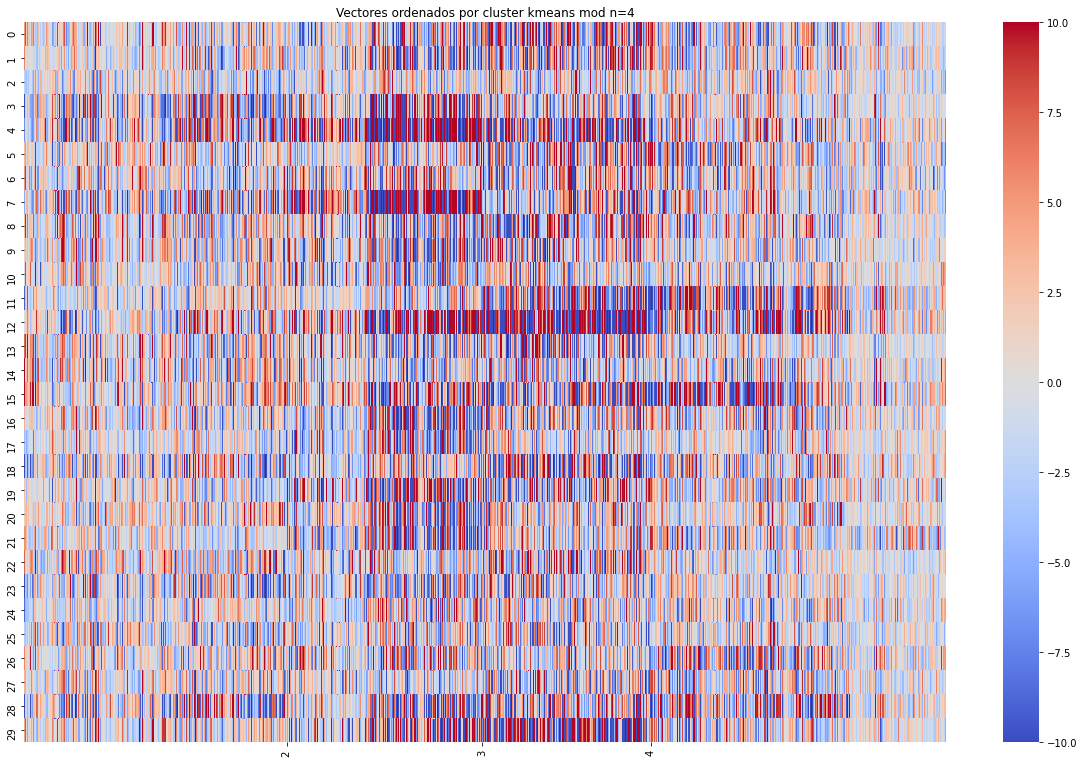

In [70]:
marcasx=np.array(np.where(np.diff(np.sort(L_k[2]))==1))

plt.figure(figsize=(16, 10))
plt.axes([0, 0, 1, 1])
sns.heatmap(X_clean_pred, vmin=-10, vmax=10, cmap='coolwarm')
plt.title('Vectores ordenados por cluster kmeans mod n=' + str(4))
plt.xticks(marcasx[0,:],labels=list(map(str, np.arange(2,4+1))))
plt.show()

In [71]:
X_clean.T

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
5,-4.90590,-5.8438,-6.38060,5.61930,13.21500,-10.3510,-0.732880,6.38300,-10.14500,-1.57980,...,-1.13120,-6.1538,-1.47650,1.92040,5.56840,-4.75890,3.1592,-6.66760,15.31600,-7.45820
10,7.63770,5.8280,-5.03080,-9.04660,-7.75150,4.4265,0.030366,-2.99750,1.61370,6.32360,...,2.53860,-2.0199,5.09860,-6.50460,-3.08470,0.46798,4.2657,4.08880,-10.48200,6.45020
21,-1.68830,-6.9348,1.04300,5.23440,7.25420,-6.8694,-1.450900,5.83270,-0.81021,-4.38280,...,2.91930,-4.0898,-3.08910,3.29280,3.30410,-1.75380,2.3473,-3.61120,5.32080,-3.41470
28,-0.79600,-1.6378,5.90230,2.30480,-2.57290,2.7789,-0.978660,0.17811,-1.85080,-0.17094,...,-5.62320,0.4648,-2.75840,6.10500,5.25630,-2.40930,-7.2843,3.59050,3.74620,0.15031
33,1.87460,6.8574,-0.41469,0.34399,3.00500,1.5043,1.461300,2.32390,1.66160,-4.51260,...,4.69570,-1.1212,-2.32960,-0.92472,-4.76060,6.54000,1.7721,0.35679,-2.93360,0.86101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76783,3.64540,2.6903,-1.96860,-3.82580,-0.82942,4.4352,5.491600,5.31490,2.37180,-0.15966,...,-2.78500,1.5869,-0.61506,-1.81290,-7.79400,1.93510,-2.7693,3.32890,-3.60430,4.49270
76788,-4.59410,-5.3179,-1.96700,2.49390,1.60230,-13.6550,-9.927800,-2.01680,-4.04800,0.25884,...,-0.99982,-7.5061,6.66900,0.96319,4.16370,-4.67180,10.1370,-7.74520,6.88590,-4.51790
76796,-0.23344,-2.3636,-7.45300,-3.94020,0.96299,-9.4888,-6.900400,-3.00350,0.17497,4.30240,...,4.45430,-8.2994,10.63400,-4.05610,0.37701,-5.20780,8.6750,-0.99986,-2.01650,-1.53520
76800,-0.88499,4.5809,6.26780,6.12990,-2.76110,-3.4339,-5.628000,-8.34130,-0.41654,1.08290,...,3.62930,-1.1062,-1.37160,4.93870,7.67810,1.53770,-1.8493,2.57210,-0.18579,-2.06950


In [169]:
d_meta = gower.gower_matrix(X_clean.T)

In [ ]:
Z = linkage(d_meta, 'ward')

/Users/fran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


In [ ]:
plt.title('Dendrograma, ccc = %0.2f')
plt.xlabel('registros')
plt.ylabel('distancia')
dn = dendrogram(Z,labels=agg_clustering.labels_)

# Tarea 4: Visualización
Para los distintos algoritmos, visualizar los datos y las etiquetas de cluster asignadas en baja dimensión con alguna técnica de reducción (PCA, TSNE, MDS, etc). Esto se puede repetir para alguna variación que encuentren interesante, como para distintos valores de k o distintas nociones de distancia.

In [72]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib as mpl

## Visualización PCA

Varianza explicada [0.39166672 0.1414166  0.11085522 0.08606292]
Varianza explicada total 0.7300014533786718


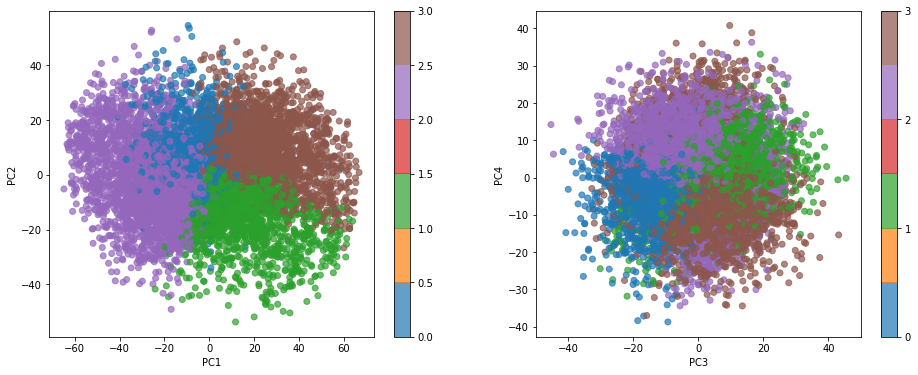

In [63]:
pca = PCA(n_components=4)
Xred = pca.fit_transform(X_clean.T)

cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', plt.cm.tab10(np.arange(6)), 6)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)

plt.scatter(Xred[:, 0], Xred[:, 1], c=KM_med.labels_, cmap=cmap, alpha=0.7)
plt.colorbar();
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.subplot(1,2,2)
plt.scatter(Xred[:, 2], Xred[:, 3], c=KM_med.labels_, cmap=cmap, alpha=0.7)
plt.colorbar(ticks=range(6));
plt.xlabel('PC3')
plt.ylabel('PC4')

print('Varianza explicada',pca.explained_variance_ratio_)
print('Varianza explicada total',pca.explained_variance_ratio_.sum())

In [ ]:
pca = PCA(n_components=4)
Xred = pca.fit_transform(X_clean.T)

cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', plt.cm.tab10(np.arange(6)), 6)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)

plt.scatter(Xred[:, 0], Xred[:, 1], c=agg_clustering.labels_, cmap=cmap, alpha=0.7)
plt.colorbar();
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.subplot(1,2,2)
plt.scatter(Xred[:, 2], Xred[:, 3], c=agg_clustering.labels_, cmap=cmap, alpha=0.7)
plt.colorbar(ticks=range(6));
plt.xlabel('PC3')
plt.ylabel('PC4')

print('Varianza explicada',pca.explained_variance_ratio_)
print('Varianza explicada total',pca.explained_variance_ratio_.sum())

## Visualización t-SNE

In [64]:
tsne = TSNE(n_components=4, perplexity=5, 
            metric='cosine', method='exact', 
            square_distances=True, n_jobs=-2, verbose=-1)

In [81]:
Xred = tsne.fit_transform(X_clean.T)

/Users/fran/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/fran/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 11972
[t-SNE] Computed conditional probabilities for sample 2000 / 11972
[t-SNE] Computed conditional probabilities for sample 3000 / 11972
[t-SNE] Computed conditional probabilities for sample 4000 / 11972
[t-SNE] Computed conditional probabilities for sample 5000 / 11972
[t-SNE] Computed conditional probabilities for sample 6000 / 11972
[t-SNE] Computed conditional probabilities for sample 7000 / 11972
[t-SNE] Computed conditional probabilities for sample 8000 / 11972
[t-SNE] Computed conditional probabilities for sample 9000 / 11972
[t-SNE] Computed conditional probabilities for sample 10000 / 11972
[t-SNE] Computed conditional probabilities for sample 11000 / 11972
[t-SNE] Computed conditional probabilities for sample 11972 / 11972
[t-SNE] Mean sigma: 0.036220


KeyboardInterrupt: 

In [ ]:
plt.scatter(Xred[:,0], Xred[:,1], c=KM_med.labels_, cmap=plt.cm.Spectral, alpha=0.7)
plt.colorbar();

# Tarea 5: Comparación de medidas de los microestados
Calcule el ajuste de los datos de EEG a los prototipos verbose=croestados hallados en la
Tarea 2 para cada registro. Realice un suavizado de las series temporales (puede utilizar
una ventana promedio móvil) y asigne a cada punto temporal el mapa prototipo que presente
mayor correlación.
A partir de aca debe elegir al menos uno de los siguientes medidas para comparar entre
ambas condiciones experimentales (antes y después del aprendizaje): (ver medidas en d’Croz
-Baron y colaboradores [3])
Duración promedio de cada microestado.
Frecuencia de ocurrencia.
Fracción de tiempo cubierto.
Global Explanined Variance.

In [109]:
# a los datos originales hacer la predicción. Primero suavizar (moving average).

In [73]:
gfp_all, gfp_peaks_all, gfp_values_all, gfp2_all, n_gfp_all = calculo_gfp(df_all_eeg_data, srate, 'Nope')

In [85]:
df_all_eeg_data_T = df_all_eeg_data.T.copy()

In [87]:
for col in df_all_eeg_data_T.columns:
    df_all_eeg_data_T.loc[:, f'{col}_roll'] = df_all_eeg_data_T[col].rolling(window=7).mean()

In [101]:
cols_roll = [x for x in df_all_eeg_data_T.columns if 'roll' in str(x)]
cols = [x for x in df_all_eeg_data_T.columns if 'roll' not in str(x)]

In [118]:
df_all_eeg_data_T.loc[:, cols_roll]

,0_roll,1_roll,2_roll,3_roll,4_roll,5_roll,6_roll,7_roll,8_roll,9_roll,...,20_roll,21_roll,22_roll,23_roll,24_roll,25_roll,26_roll,27_roll,28_roll,29_roll
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76805,0.795614,1.158791,0.609200,1.577289,-1.667749,0.041671,-1.034000,-3.771749,-1.111574,-0.541378,...,1.546367,-0.394771,-1.396534,0.614843,2.533121,1.451167,0.867860,0.490248,-0.278281,-3.218414
76806,1.027678,0.364306,-1.203129,0.596589,-0.718691,-0.134271,-0.496290,-1.868906,-1.351249,-0.523078,...,1.098124,-0.286997,-1.139059,-0.182171,0.834350,1.383996,1.753761,-0.021439,0.017514,-3.494629
76807,0.946134,-0.538151,-3.010429,-0.214330,0.661251,-0.844429,-0.204119,0.312994,-1.642243,-0.460206,...,0.797924,-0.523883,-0.352244,-0.799300,-0.868321,1.204391,2.754661,-0.799797,0.492227,-3.901643
76808,0.681964,-1.186080,-4.078300,-0.504544,2.092594,-1.407729,0.293481,2.401294,-1.889514,-0.573792,...,0.511001,-0.647111,0.334570,-0.961457,-2.349150,1.300511,3.222833,-1.632882,1.061891,-4.304443


In [153]:
for idx, row in df_all_eeg_data_T.loc[6:, cols_roll].iterrows():
    corr = {'cluster': '', 'corr': 0}
    for idx2, i in enumerate(maps_k[2]):
        corr_ = np.abs(np.corrcoef(row.values, i))[0][1]
        if corr_ > corr['corr']:
            corr['cluster'] = idx2
            corr['corr'] = corr_
    df_all_eeg_data_T.loc[idx, 'class'] = corr['cluster']

In [157]:
df_all_eeg_data_T['class'].value_counts(dropna=False)

0.0    21616
3.0    20737
1.0    19151
2.0    15300
NaN        6
Name: class, dtype: int64

In [158]:
df_all_eeg_data_T

,0,1,2,3,4,5,6,7,8,9,...,21_roll,22_roll,23_roll,24_roll,25_roll,26_roll,27_roll,28_roll,29_roll,class
0,-2.638500,-2.43280,2.5797,0.051955,-3.88590,-6.62310,1.90950,1.6460,-6.3994,1.580800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-3.363500,-3.35150,4.3260,3.482100,-3.99290,-7.58830,2.76430,2.1408,-9.9395,1.312700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-4.420800,-4.53860,4.0322,7.137500,-1.08200,-8.43630,2.84230,3.4516,-12.9450,0.038316,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-5.369000,-5.68980,1.2786,9.307900,4.09050,-9.45070,1.89240,4.9516,-14.1200,-1.365600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-5.655900,-6.27190,-2.8409,8.822300,9.62400,-10.35100,0.41397,6.0457,-12.9900,-2.053800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76805,1.541000,-1.52470,-6.8886,-4.748700,0.53766,2.75940,3.16660,2.3010,-1.0065,0.098257,...,-0.394771,-1.396534,0.614843,2.533121,1.451167,0.867860,0.490248,-0.278281,-3.218414,1.0
76806,-0.075854,-1.54650,-7.6787,-3.085100,3.71860,-3.31200,-0.86483,4.6168,-1.4845,1.802300,...,-0.286997,-1.139059,-0.182171,0.834350,1.383996,1.753761,-0.021439,0.017514,-3.494629,1.0
76807,-1.455800,-1.73630,-6.3833,0.453470,6.89850,-8.40500,-3.58280,6.9320,-2.4535,1.523000,...,-0.523883,-0.352244,-0.799300,-0.868321,1.204391,2.754661,-0.799797,0.492227,-3.901643,3.0
76808,-1.586400,-1.50540,-2.7014,4.134800,7.97180,-7.73380,-1.61140,8.1556,-3.1283,-1.004100,...,-0.647111,0.334570,-0.961457,-2.349150,1.300511,3.222833,-1.632882,1.061891,-4.304443,3.0
